In [1]:
from __future__ import division, print_function
import numpy as np
import pandas as pd
from sympy import *
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages
from functools import partial, reduce
from itertools import combinations
from scipy.stats import percentileofscore
import affinity as af
import ratlib as rat

%matplotlib inline 

In [2]:
data = pd.read_excel('~/GIT/collinearity/database/sidis/expdata/1008.xlsx')
tab = pd.read_excel('~/GIT/collinearity/notebooks/SIDIS_Proximity/1008_Affinity.xlsx')

In [3]:
class Rfilter(object):

    def __init__(self, hadron='pi+', fudge=[0, 0]):
        #self.M = 0.938
        self.M = 0.94
        self.M2 = self.M**2
        self.set_Mh(hadron)
        

        self.fudge1 = fudge[0]
        self.fudge2 = fudge[1]

        self.MiT2 = 0.5 + 0.3 * fudge[0]
        self.MfT2 = 0.5 + 0.3 * fudge[1]
        self.kT = 0
    
        self.MX = 1.3
        self.Ma = 1.5
        self.Mb = 0.3
        self.deltaM = 0.3
        self.MJ = 0.3
        
        self.MiT = self.MiT2**0.5
        self.MfT = self.MfT2**0.5
        self.kT2 = self.kT**2
        
        # from paper, we need kf2, deltakT2, ki2
        # we need to have a way to vary them!
        self.kf       = 0
        self.ki       = 0
        self.kf2      = self.kf**2
        self.ki2      = self.ki**2
        self.deltakT  = 0
        self.deltakT2 = self.deltakT**2
        
    def set_ki(self,ki):
        self.ki = ki
        self.ki2 = ki**2
        
    def set_kf(self,kf):
        self.kf = kf
        self.kf2 = kf**2
        
    def set_kT(self,kT):
        self.kT = kT
        self.kT2 = kT**2
        
    def set_deltakT(self,deltakT):
        self.deltakT = deltakT
        self.deltakT2 = self.deltakT**2
        
    def set_Mh(self, hadron):
        if hadron == 'pi+':
            self.Mh = 0.135  #  
        if hadron == 'pi-':
            self.Mh = 0.135  #  
        if hadron == 'pi0':
            self.Mh = 0.135  #  
        if hadron == 'k+':
            self.Mh = 0.493
        if hadron == 'k-':
            self.Mh = 0.493
        if hadron == 'k+':
            self.Mh = 0.493
        if hadron == 'h+':
            #self.Mh = 0.135
            self.Mh = 0.14
        if hadron == 'h-':
            self.Mh = 0.135
        self.Mh2 = self.Mh**2
   
    def set_kibT(self,kibT):
        self.kibT = kibT
        self.kibT2 = kibT**2
        
    def set_phi(self,phi):
        self.phi = phi
    
    def set_xi(self,xi):
        self.xi = xi
        
    def set_zeta(self,zeta):
        self.zeta = zeta
    
    def set_MBT(self,PhT):
        self.MBT = np.sqrt( self.Mh2 + (PhT**2 ))
        
    def set_xn(self, x, Q2):
        self.xn = (2 * x / (1 + np.sqrt(1 + 4 * x**2 * self.M2 / Q2)))
    
    def set_zn(self, x, z, Q2, PhT, hadron):
        self.set_xn(x,Q2)
        self.set_Mh(hadron)
        self.set_MBT(PhT)
        self.zn =  self.xn * z/ (2 * x) * ( 1. + np.sqrt( 1.- 4. * self.M2 * self.MBT**2 * x**2 /  ( Q2**2 * z**2) ) )
        
        self.xn * z/ (2 * x) * ( 1. + np.sqrt( 1.- 4. * self.M2 * self.MBT**2 * x**2 /  ( Q2**2 * z**2) ) )
        
    def set_MfT(self):
        self.MfT = np.sqrt(self.kT**2 + self.MJ**2 +
                           self.deltaM**2 * self.fudge2)
    def set_MiT(self,x,Q2):
        self.set_xn(x, Q2)
        self.MiT = np.sqrt((self.xn * self.kT**2 + self.xn * (self.Ma + self.Mb / np.sqrt(self.xn))
                            ** 2 - (1 - self.xn) * self.xn * self.M2 + self.deltaM**2 * self.fudge1) / (1 - self.xn))
    def set_W2(self,x,Q2):
        self.W2 = Q2 * (1. - x) / x + self.M2
    
    def set_yh(self, x, z, Q2, PhT, hadron, sign=-1):
        self.set_xn(x, Q2)
        self.set_Mh(hadron)
        expy = Q2**0.5 * z * (Q2 - self.xn**2 * self.M2)\
            / (2 * self.M2 * self.xn**2 * (self.Mh2 + PhT**2)**0.5)\
            + sign * Q2**0.5 / (self.xn * self.M) * (z**2 * (Q2 - self.xn**2 * self.M2)**2
                                        / (4 * self.M2 * self.xn**2 * (self.Mh2 + PhT**2)) - 1)**0.5
        self.yh = np.log(expy)
        
    def get_ki2(self):
        return self.ki2
    
    def get_kf(self):
        return self.kf
    
    def get_W2(self):
        return self.W2

    def get_MBT(self):
        return self.MBT
        
    def get_MiT(self):
        return self.MiT

    def get_MfT(self):
        return self.MfT

    def get_xn(self):
        return self.xn

    def get_yh(self):
        return self.yh

    def get_zn(self):
        return self.zn
        
# rapidity of the target

    def get_yp(self, x, Q2):
        self.set_xn(x, Q2)
        return np.log(np.sqrt(Q2) / (self.xn * self.M))

    def get_yi(self, Q2):
        return 0.5 * np.log(Q2 / self.MiT**2)

    def get_yf(self, Q2):
        return -0.5 * np.log(Q2 / self.MfT**2)

    def get_MhT(self, PhT):
        return np.sqrt(self.Mh2 + PhT**2)
    
    def get_kibT(self,kibT):
        return self.kibT
    
    def get_M(self):
        return self.M
    
    def get_Mh(self):
        return self.Mh
    
    def get_Mh2(self):
        return self.Mh2
    
    def get_R(self, x, z, Q2, PhT, hadron):
        
        self.set_zn(x, z, Q2, PhT, hadron)
        zn2 = self.zn**2
        self.set_xn(x, Q2)
        znhat = self.zn/self.zeta
        xnhat = self.xn/self.xi
        qT = -PhT/self.zn
        
        # from paper..
        Ph_kf = ((((self.Mh2+zn2*qT**2)*znhat)/(2*self.zn))+(self.zn*((-znhat*qT+self.deltakT)**2+ \
                    self.kf2)/(2*znhat))) + self.zn*qT*(-znhat*qT+self.deltakT)
        Ph_ki = ((((self.Mh2+zn2*qT**2)*(xnhat*(self.ki2 + self.kibT2)))/(2*Q2*self.zn)) + \
                 (self.zn*Q2)/(2*xnhat))+self.zn*qT*self.kibT
        
        return np.abs(Ph_kf / Ph_ki)
    
    def get_R1S(self, x, z, Q2, PhT, hadron):
        
        self.set_zn(x, z, Q2, PhT, hadron)
        zn2 = self.zn**2
        self.set_xn(x, Q2)
        znhat = self.zn/self.zeta
        xnhat = self.xn/self.xi
        qT = -PhT/self.zn
        
        R1 = 1/self.zeta*(self.Mh2+self.zeta**2*(self.deltakT2+self.kf2))/((self.Mh2+zn2*qT**2)* \
             (self.ki2+self.kibT**2)*(self.xn/(self.zn*Q2*self.xi))+ (self.zn*Q2*self.xi/self.xn) + \
             2*self.zn*qT*self.kibT*np.cos(self.phi))
        return R1
        
        
# R0, Eq. (4.14)...
    def get_R0(self, Q2):
        """
        Collinearity ratio defined in the paper Eq. (4.15)
        """
        R0 = (np.maximum(np.maximum(self.ki**2/Q2,self.kf**2/Q2),self.kT**2/Q2))
        #print(R0)
        return  R0
        
        
# We call R1 in the new paper what was R in the previous...
    def get_R1(self, x, z, Q2, PhT, hadron):
        Rval.set_Mh(hadron)
        """
        Collinearity ratio defined in the paper Eq. (4.15)
        """
        return  self.get_R(x, z, Q2, PhT, hadron)

# R2 from Eq. (4.17)        
    def get_R2(self, x, z, Q2, PhT, hadron):
        self.set_Mh(hadron)
        self.set_zn(x, z, Q2, PhT, hadron)
        znhat = self.zn/self.zeta
        qT = -PhT/self.zn
        # from paper..
        return(np.abs( -(1.-znhat) - znhat*qT**2/Q2 - (1.-znhat)*self.kf2/(znhat*Q2) - \
                      self.deltakT2/(znhat*Q2) + 2.*qT*self.deltakT/Q2 ))
    
   


In [4]:
%%time

hadron = 'h+'
fudge = [0,0]
Rval = Rfilter(hadron = hadron,fudge = fudge)
Rval.set_kT(.1)
Rval.set_ki(.1)
Rval.set_kf(.1)
Rval.set_deltakT(.3)
Rval.set_kibT(0.2)
Rval.set_xi(0.3)
Rval.set_zeta(0.3)
Rval.set_phi(0)

x = .2
Q2 = 3**2
z = .3
pT = .1
M = 0.94
M_h = .14

Rval.set_xn(x, Q2)
xn = Rval.get_xn()
Rval.set_zn(x, z, Q2, pT, hadron)
zn = Rval.get_zn()
R1 = Rval.get_R1(x, z, Q2, pT, 'h+')
R2 = Rval.get_R2(x, z, Q2, pT, 'h+')
R1S2 = Rval.get_R1S( x, z, Q2, pT, hadron)
print('Rfilter     ',R1,'',R2)
print('Rfilter R1S ',R1S2)

# From ratios.py
M= .94
M_h=.14
x_bj = .2
Q = 3
z_h = .3
P_t = 0.1

    
xi = .3
zeta = .3
delta_k_t = .3 
k_i_t = .2 
M_ki = .1 
M_kf = .1 
szn = rat.zn(z_h,x_bj,Q,M,M_h,P_t)
q_t = -P_t/szn
eta = .1

R1S = rat.get_R1( M,M_h,x_bj,z_h,eta,Q,q_t,xi,zeta,delta_k_t,k_i_t,M_ki,M_kf)
R2S = rat.get_R2(M,M_h,x_bj,z_h,eta,Q,q_t,xi,zeta,delta_k_t,k_i_t,M_ki,M_kf)

sxN = rat.get_xN(M,M_h,x_bj,z_h,eta,Q,P_t,xi,zeta,delta_k_t,k_i_t,M_ki,M_kf)
sxn = rat.xnac(x_bj,M,Q)
print('ratlib.py zn = ',szn,' Rfilter zn = ',zn)
print('ratlib.py xn = ',sxn,'ratlib.py xN = ',sxN,' Rfilter xn = ',xn)
print('ratios.py   ',R1S,'',R2S)
print(0.023776044983519918,
0.04879270850634498)


Rfilter      0.023775178126167786  0.048792708506345
Rfilter R1S  0.02377517812616779
ratlib.py zn =  0.29878813895610384  Rfilter zn =  0.29878813895610384
ratlib.py xn =  0.19922068675196355 ratlib.py xN =  0.19922068675196355  Rfilter xn =  0.19922068675196355
ratios.py    0.023776044983519918  0.04879270850634498
0.023776044983519918 0.04879270850634498
CPU times: user 2.86 ms, sys: 0 ns, total: 2.86 ms
Wall time: 2.22 ms


In [16]:
R0 =  0.0011111111111111113 
R1 =  0.023775178126167786 
R2 =  0.04879270850634477


In [5]:
# Proximity is defined for a sphere of a selected radius(p) by the following function
# This notebook does not use this function to compare ratios.py with Rfilter

def Proximity(data,domain1,domain2,domainPhi,p,N,fudge):
    """
    data    = any Pandas DataFrame should do as long as it contains x,z,Q2, and pT
    domain1 = 
    domain2 = 
    p       = radius of sphere representing the demarcation of the proximity
    hadron  = any hadron found in the data
    fudge   = idk what fudge is so I did the right thing and passed it along 
    """
    
    #data.loc[:,'proximity'] = 0.
    
    
    for i in range(len(data)):
        
        hadron = data.loc[i,'hadron']
        Rval = Rfilter(hadron = hadron,fudge = fudge)
        # Creates vectors of length N made from uniform random numbers in defined domains.
        zeta = np.random.uniform(data.loc[i,'z']-.1,data.loc[i,'z']+.1,N)
        ki = np.random.uniform(domain1[0],domain1[1],N)
        kf = np.random.uniform(domain1[0],domain1[1],N)
        kT = np.random.uniform(domain1[0],domain1[1],N)
        kibT = np.random.uniform(domain1[0],domain1[1],N)
        deltakT = np.random.uniform(domain2[0],domain2[1],N)
        xi = np.linspace(domain2[0],domain2[1],N)
        phi = np.linspace(domainPhi[0],domainPhi[1],N)
        
        # Sets our parameters for Rfilter
        Rval.set_ki(ki)
        Rval.set_kf(kf)  
        Rval.set_kT(kT)
        Rval.set_kibT(kibT)
        Rval.set_deltakT(deltakT)
        Rval.set_zeta(zeta)
        Rval.set_phi(phi)
        Rval.set_xi(xi)
        
        # Gets Ratios from Rfilter 
        R0 = Rval.get_R0(data.loc[i,'Q2'])             
        R1 = Rval.get_R1(data.loc[i,'x'], data.loc[i,'z'], data.loc[i,'Q2'], data.loc[i,'pT'], hadron)
        R2 = Rval.get_R2(data.loc[i,'x'], data.loc[i,'z'], data.loc[i,'Q2'], data.loc[i,'pT'], hadron)
        SR1 = Rval.get_R1S(data.loc[i,'x'], data.loc[i,'z'], data.loc[i,'Q2'], data.loc[i,'pT'], hadron)
        
        # proximity uses Rfiler for R0, R1, R2 with Alexei's method of proximity using error to define what
        # is inside sphere of radius p(typically p = 1)
        data.loc[i,'proximity'] = sum(1 for i in range(N) if (R0[i]**2+R1[i]**2+R2[i]**2)<p)/N
        
        # affinity uses Rfilter for R1 and R2 but with Sterlings approach for Saffinity %
        data.loc[i,'affinity']  = sum([1 for i in range(N) if SR1[i]<0.3 if R2[i]<0.3])/N  
        
        # Input for Sterlings code
        x=data.loc[i,'x']
        z=data.loc[i,'z']
        Q=data.loc[i,'Q2']**.5
        val=data.loc[i,'value']
        P_t=data.loc[i,'pT']
        
        #M= Rval.get_M()
        #M_h = Rval.get_Mh()
        M= .94
        M_h = .14
        z_N = rat.zn(z,x,Q,M,M_h,P_t)
        q_t = -P_t/z_N
        
        #M_h=.14
        eta = rat.get_eta( M,M_h,x,z,Q,q_t)
        
        sR1 = rat.get_R1( M,M_h,x_bj,z_h,eta,Q,q_t,xi,zeta,deltakT,kibT,ki,kf)
        sR2 = rat.get_R2( M,M_h,x_bj,z_h,eta,Q,q_t,xi,zeta,deltakT,kibT,ki,kf)
        
        # Saffinity uses Sterlings equations in ratlib.py
        data.loc[i,'Saffinity'] = sum([1 for i in range(N) if sR1[i]<0.3 if sR2[i]<0.3])/N 
        if i == 2:
            for j in range(len(R1)):
                print('R1 Rfilter =          ',R1[j],'\nR1 Sterling Rfilter = ',SR1[j],'\nratlib R1 =           ',sR1[j],'\n')
    return data

In [6]:
%%time
N = 1000
p = 1
fudge = [0,0]
domain1 = [0,.1]
domain2 = [0.3,0.4]
domainPhi = [0,0]
data = Proximity(data,domain1,domain2,domainPhi,p,N,fudge)

R1 Rfilter =           0.015958204294605677 
R1 Sterling Rfilter =  0.015958204294605708 
ratlib R1 =            0.013573499182478556 

R1 Rfilter =           0.021681170323947938 
R1 Sterling Rfilter =  0.021681170323947924 
ratlib R1 =            0.018459692441259907 

R1 Rfilter =           0.026291454533338438 
R1 Sterling Rfilter =  0.026291454533338497 
ratlib R1 =            0.022365251492619975 

R1 Rfilter =           0.02632011996525126 
R1 Sterling Rfilter =  0.026320119965251305 
ratlib R1 =            0.022387794303799644 

R1 Rfilter =           0.013608112071185074 
R1 Sterling Rfilter =  0.013608112071185067 
ratlib R1 =            0.011558507080442157 

R1 Rfilter =           0.016304506832161263 
R1 Sterling Rfilter =  0.016304506832161277 
ratlib R1 =            0.013856589826693856 

R1 Rfilter =           0.014873389591683252 
R1 Sterling Rfilter =  0.014873389591683245 
ratlib R1 =            0.012659117554488097 

R1 Rfilter =           0.01835302432059261 
R1 St

R1 Sterling Rfilter =  0.019262920117746916 
ratlib R1 =            0.016375798364657215 

R1 Rfilter =           0.01825396239128678 
R1 Sterling Rfilter =  0.01825396239128682 
ratlib R1 =            0.015510503707430548 

R1 Rfilter =           0.011553624287188046 
R1 Sterling Rfilter =  0.011553624287188043 
ratlib R1 =            0.009827353237870312 

R1 Rfilter =           0.02347745731257914 
R1 Sterling Rfilter =  0.023477457312579147 
ratlib R1 =            0.019979479119445632 

R1 Rfilter =           0.012127045033802162 
R1 Sterling Rfilter =  0.012127045033802181 
ratlib R1 =            0.01031197049419409 

R1 Rfilter =           0.01903477919369466 
R1 Sterling Rfilter =  0.019034779193694697 
ratlib R1 =            0.0161906588289576 

R1 Rfilter =           0.013849818759573038 
R1 Sterling Rfilter =  0.01384981875957302 
ratlib R1 =            0.011770455242376292 

R1 Rfilter =           0.02072682782994338 
R1 Sterling Rfilter =  0.020726827829943343 
ratlib R1 = 

CPU times: user 10.2 s, sys: 87 ms, total: 10.3 s
Wall time: 10.2 s


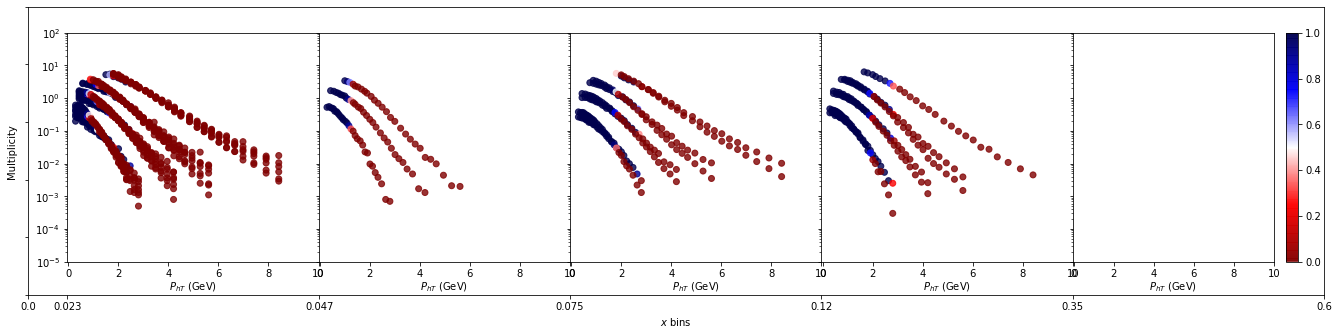

In [27]:
dat =data
dat['qT'] = dat['pT']/dat['z']
xBin = np.array([0.023,0.047,0.075,0.12,0.35,0.6]) # Bins for x used to plot Pt
Q2Bin = np.array([1.0,10]) # **NOTE** includes all Q2 data, therefore all value data is plotted vs. Pt
zBin = np.array([0.1, 0.2,0.25,0.3, 0.375, 0.475, 0.6, 0.8, 1.1]) # catagories for z to be plotted individually 
                                                                 # in each subplot
Phperp = np.array([ 0.0, 0.15, 0.25, 0.35, 0.45, 0.6, 0.8, 1.2]) 

# Binning data
dat['xBin'] = pd.cut(dat['x'], xBin,labels = False, retbins=0)
dat['Q2Bin'] = pd.cut(dat['Q2'], Q2Bin,labels = False, retbins=0)
dat['zBin'] = pd.cut(dat['z'], zBin,labels = False, retbins=0)

# Bins for x and y that have non-empty intersection
pTdat = [0,1,2,3,4] # xBins that overlap Q2Bins
valuedat = [0] # Q2bins that overlap xBins
 
# Initialize the figure
fig1 = plt.figure(figsize=(18, 4),facecolor="white") 
globalGrid = gridspec.GridSpec(1, 1,left=0.03,right=1,top=.91,bottom=.115, 
                             wspace=0.0, hspace=0.0) # plot for subplot matrix as 1x1 matrix
innerGrid = gridspec.GridSpecFromSubplotSpec(1,5, subplot_spec=globalGrid[0], 
                             wspace=0.0, hspace=0.0) # 1X5 subplot grid 

# Figure properties
ax = fig1.add_axes([0,0,1,1]) 
ax.xaxis.set_ticks([0,.3,2.245,4.18,6.12,8.06,10 ])
xticklabels = np.array([0,0.023,0.047,0.075,0.12,0.35,0.6]) 
ax.set_yticklabels("")
ax.set_xticklabels(xticklabels)
ax.set_xlabel(r"$x$ bins") 
ax.set_ylabel(r"Multiplicity")
#cmap = reverse_colourmap(cmap=plt.get_cmap('seismic'), name = 'my_cmap_r')
cmap=plt.get_cmap('seismic_r')

for f,F in zip(range(len(pTdat)),pTdat):       
    for j,J in zip(range(len(valuedat)),valuedat):
        
        ax = fig1.add_subplot(innerGrid[f]) # add subplot in innerGrid
        
        for z in range(len(zBin)-1): 
           
            databin = dat[dat['xBin'].isin([F]) & dat['Q2Bin'].isin([J]) & dat["zBin"].isin([z])]
            
            if f != 0:
               
                ax.scatter(databin['qT'],databin['value'], c=databin['proximity'],
                           cmap=cmap, alpha=0.8)
                ax.set_xlim([-0.05,10.0])                
                ax.set_ylim([10**(-5),10**2])
                ax.set_xlabel(r"$P_{hT}$ (GeV)",labelpad=1)
                ax.set_yscale('log')
                ax.set_yticklabels('')
               
            else:
              
                plot = ax.scatter(databin['qT'],databin['value'], c=databin['proximity'], 
                                  cmap=cmap, alpha=0.8)
                ax.set_xlabel(r"$P_{hT}$ (GeV)",labelpad=1)
                ax.set_xlim([-0.05,10.0])
                ax.set_ylim([10**(-5),10**2])
                ax.set_yscale('log')
                
fig1.colorbar(plot)
plt.show()

In [26]:
dat['qT'] = dat['pT']/dat['z']
print(min(dat.qT),max(dat.qT))

0.28867513459481287 8.41130192063036


In [7]:
# Trying out symbolic math operations in python using sympy

R1_str_expr_denominator = '1/2*((M_B**2+z_N**2*q_T**2)*(k_f**2+k_iT**2)*x_N/(z_N*Q**2*xi)+z_N*Q**2*xi/x_N+2*z_N*q_T*k_iT*cos(phi_i))'
denominator = sympify(R1_str_expr_denominator)
R1_str_expr_numerator = "1/(2*zeTa)*(M_B**2+zeTa**2*(delta_kT**2+k_f**2))"
numerator = sympify(R1_str_expr_numerator)
R1 = sympify(numerator/denominator)
R1

(M_B**2 + zeTa**2*(delta_kT**2 + k_f**2))/(2*zeTa*(Q**2*xi*z_N/(2*x_N) + k_iT*q_T*z_N*cos(phi_i) + x_N*(M_B**2 + q_T**2*z_N**2)*(k_f**2 + k_iT**2)/(2*Q**2*xi*z_N)))

In [8]:
R1 = R1.subs('q_T','-p_T/z_N')
R1 = R1.subs('z_N','x_N*z/(2*x)*(1+sqrt(1-(4*M**2*M_BT**2*x**2)/(Q**4*z**2)))')
R1 = R1.subs('x_N','2*x/(1+sqrt(1+4*x**2*M**2/Q**2))')
R1 = R1.subs('M_BT','sqrt(M_B**2+p_T**2)')
simplify(R1)

2*Q**2*x*xi*z*(M_B**2 + zeTa**2*(delta_kT**2 + k_f**2))*(sqrt((-4*M**2*x**2*(M_B**2 + p_T**2) + Q**4*z**2)/(Q**4*z**2)) + 1)/(zeTa*(Q**4*xi**2*z**2*(sqrt((-4*M**2*x**2*(M_B**2 + p_T**2) + Q**4*z**2)/(Q**4*z**2)) + 1)**2 - 4*Q**2*k_iT*p_T*x*xi*z*(sqrt((-4*M**2*x**2*(M_B**2 + p_T**2) + Q**4*z**2)/(Q**4*z**2)) + 1)*cos(phi_i) + 4*x**2*(M_B**2 + p_T**2)*(k_f**2 + k_iT**2)))

In [9]:
# Checking R1 for ratios.py parameter values

M= .94
M_B=.14
x = .2
Q = 3
z = .3
p_T = 0.1 
xi = .3
zeTa = .3
delta_kT = .3 
k_iT = .2 
M_ki = .1 
M_kf = .1 
eta = .1

R1 = R1.subs({'Q':3,'z':.3,'xi':.3,'zeTa':.3,'delta_kT':.3,'k_iT':.2,'x':.2,'M':.94,'M_B':.14,'p_T':.1, \
              'k_f':.1,'k_i':.1,'phi_i':0})

In [10]:
print(R1)


0.0237751781261678


In [11]:
R2_str_exp = 'abs( -(1-zhat_N)-zhat_N*q_T**2/Q**2 - (1 - zhat_N)*kf**2/(zhat_N*Q**2) - delta_kT**2/(zhat_N*Q**2) + 2*q_T*delta_kT/Q**2 )'
R2 = sympify(R2_str_exp)
R2

abs(zhat_N - 1 - delta_kT**2/(Q**2*zhat_N) + 2*delta_kT*q_T/Q**2 - kf**2*(1 - zhat_N)/(Q**2*zhat_N) - q_T**2*zhat_N/Q**2)

In [12]:
R2 = R2.subs('q_T','-p_T/z_N')
R2 = R2.subs('zhat_N','z_N/zeTa')
R2 = R2.subs('z_N','x_N*z/(2*x)*(1+sqrt(1-(4*M**2*M_BT**2*x**2)/(Q**4*z**2)))')
R2 = R2.subs('x_N','2*x/(1+sqrt(1+4*x**2*M**2/Q**2))')
R2 = R2.subs('M_BT','sqrt(M_B**2+p_T**2)')

simplify(R2)

abs((Q**2*z**2*(sqrt((-4*M**2*x**2*(M_B**2 + p_T**2) + Q**4*z**2)/(Q**4*z**2)) + 1)**2 - Q**2*z*zeTa*(sqrt((4*M**2*x**2 + Q**2)/Q**2) + 1)*(sqrt((-4*M**2*x**2*(M_B**2 + p_T**2) + Q**4*z**2)/(Q**4*z**2)) + 1) - p_T**2*(sqrt((4*M**2*x**2 + Q**2)/Q**2) + 1)**2 + zeTa*(sqrt((4*M**2*x**2 + Q**2)/Q**2) + 1)*(-delta_kT**2*zeTa*(sqrt((4*M**2*x**2 + Q**2)/Q**2) + 1) - 2*delta_kT*p_T*(sqrt((4*M**2*x**2 + Q**2)/Q**2) + 1) + kf**2*(z*(sqrt((-4*M**2*x**2*(M_B**2 + p_T**2) + Q**4*z**2)/(Q**4*z**2)) + 1) - zeTa*(sqrt((4*M**2*x**2 + Q**2)/Q**2) + 1))))/(Q**2*z*zeTa*(sqrt((4*M**2*x**2 + Q**2)/Q**2) + 1)*(sqrt((-4*M**2*x**2*(M_B**2 + p_T**2) + Q**4*z**2)/(Q**4*z**2)) + 1)))

In [13]:
# This block of code will be used in a .py file to import to Alexei's method of reading in data 
# It is still unfinished I will have to add the actual proximity calculation for each row in DataFrame

from numpy import *

def proximity(x,z,Q2,pT,Mh,M,zeta,xi,ki,kf,kT,kiT,deltakT,phi):
    
    R0 = (maximum(maximum(ki**2/Q2,kf**2/Q2),kT**2/Q2))
    
    R1 = 2*Q2*x*xi*z*(Mh**2+zeta**2*(deltakT**2+kf**2))*(sqrt((-4*M**2*x**2*(Mh**2+pT**2)+Q2**2*z**2) \
         /(Q2**2*z**2))+1)/(zeta*(Q2**2*xi**2*z**2*(sqrt((-4*M**2*x**2*(Mh**2+pT**2)+Q2**2*z**2) \
         /(Q2**2*z**2))+1)**2 - 4*Q2*kiT*pT*x*xi*z*(sqrt((-4*M**2*x**2*(Mh**2+pT**2)+Q2**2*z**2) \
         /(Q2**2*z**2))+1)*cos(phi)+4*x**2*(Mh**2+pT**2)*(kf**2+kiT**2)))
    
    R2 = abs((Q2*z**2*(sqrt((-4.*M**2*x**2*(Mh**2+pT**2)+Q2**2*z**2)/(Q2**2*z**2))+1)**2-Q2*z*zeta \
         *(sqrt((4.*M**2*x**2+Q2)/Q2)+1)*(sqrt((-4.*M**2*x**2*(Mh**2+pT**2)+Q2**2*z**2)/(Q2**2*z**2))+1) \
         - pT**2*(sqrt((4.*M**2*x**2+Q2)/Q2)+1)**2 - zeta*(sqrt((4*M**2*x**2+Q2)/Q2)+1) \
         *(deltakT**2*zeta *(sqrt((4*M**2*x**2+Q2)/Q2)+1)+2*deltakT*pT*(sqrt((4.*M**2*x**2+Q2)/Q2)+1)  \
         +kf**2*(-z*(sqrt((-4*M**2*x**2*(Mh**2+pT**2)+Q2**2*z**2)/(Q2**2*z**2))+1) \
         +zeta*(sqrt((4*M**2*x**2+Q2)/Q2)+1))))/(Q2*z*zeta*(sqrt((4.*M**2*x**2+Q2)/Q2)+1) \
         *(sqrt((-4*M**2*x**2*(Mh**2+pT**2)+Q2**2*z**2)/(Q2**2*z**2))+1)))
    
    return R0,R1,R2
    

In [14]:
M= .94
Mh=.14
x = .2
Q2 = 9.
z = .3
pT = 0.1 
xi = .3
zeta = .3
deltakT = .3 
kiT = .2 
ki = .1 
kf = .1 
kT = .1
phi = 0.
R0,R1,R2 = proximity(x,z,Q2,pT,Mh,M,zeta,xi,ki,kf,kT,kiT,deltakT,phi)

In [15]:
print('R0 = ',R0,'\nR1 = ',R1,'\nR2 = ',R2)

R0 =  0.0011111111111111113 
R1 =  0.023775178126167786 
R2 =  0.04879270850634477
